In [1]:
import os
import shutil
from PIL import Image
import numpy as np
import time

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

# Device configuration
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
#NVIDIA GT 630M - 2.1 <= 3.0 !!! cuDNN error: CUDNN_STATUS_ARCH_MISMATCH
device = torch.device('cpu')
device

device(type='cpu')

In [2]:
print("torch.cuda.is_available()   =", torch.cuda.is_available())
print("torch.cuda.device_count()   =", torch.cuda.device_count())
print("torch.cuda.device('cuda')   =", torch.cuda.device('cuda'))
print("torch.cuda.current_device() =", torch.cuda.current_device())

torch.cuda.is_available()   = True
torch.cuda.device_count()   = 1
torch.cuda.device('cuda')   = <torch.cuda.device object at 0x0000000009A626D8>


C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\__init__.py:117: UserWarning: 
    Found GPU0 GeForce GT 630M which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


torch.cuda.current_device() = 0


In [3]:
dir_ = "data"
market_path_train = "/Market-1501-v15.09.15/bounding_box_train"
market_path_test = "/Market-1501-v15.09.15/bounding_box_test"
dist_market_path_train = "/trainClasses"
dist_market_path_test = "/testClasses"
files_train = os.listdir(dir_ + market_path_train)
files_test = os.listdir(dir_ + market_path_test)

In [4]:
im = Image.open(dir_ + dist_market_path_train + '/' + '0' + '/' + '0002_c1s1_000451_03.jpg')

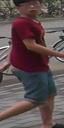

In [5]:
im

In [6]:
im_np = np.array(im)

In [7]:
h = len(im_np)
w = len(im_np[0])
v = len(im_np[0][0])
print("Size h = {}, w = {}, v = {}".format(h, w, v))

Size h = 128, w = 64, v = 3


In [4]:
#inplace = 3 - кол-во входных каналов (RGB)

class CNN_ReID(nn.Module):
    def __init__(self, inplanes=3, planes1=8, planes2=16, planes3=32, stride=1):
        super(CNN_ReID, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(inplanes, planes1, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential(nn.Conv2d(planes1, planes2, kernel_size=3, stride=1, padding=1), 
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(planes2, planes3, kernel_size=3, stride=1, padding=1), 
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 
        #self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(16 * 8 * planes3, 128) # 16*8*32 = 4096
        self.fc2 = nn.Linear(128, 751) # 16*8*32 = 4096
    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

scipy
cosine
dist

In [5]:
def load_dataset():
    data_path = dir_ + '/' + dist_market_path_train
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=1000,
        num_workers=0,
        shuffle=True
    )
    return train_loader

In [6]:
train_loader = load_dataset()

In [7]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [8]:
len(train_loader)

13

In [49]:
num_epochs = 10
weight_decay = 0.01
momentum = 0.9
learning_rate = 0.001

model = CNN_ReID().to(device)
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss() объединяет и SoftMax, и кросс-энтропийную функцию потерь
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

total_step = len(train_loader)
loss_list = []
acc_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) 
        labels = labels.to(device)
        
        # Прямой запуск
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Обратное распространение и оптимизатор
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Отслеживание точности
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 4 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.8f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total)))

Epoch [1/10], Step [4/13], Loss: 6.6264, Accuracy: 0.30000000%
Epoch [1/10], Step [8/13], Loss: 6.6224, Accuracy: 0.00000000%
Epoch [1/10], Step [12/13], Loss: 6.6244, Accuracy: 0.00000000%
Epoch [2/10], Step [4/13], Loss: 6.6234, Accuracy: 0.10000000%
Epoch [2/10], Step [8/13], Loss: 6.6241, Accuracy: 0.40000000%
Epoch [2/10], Step [12/13], Loss: 6.6234, Accuracy: 0.20000000%
Epoch [3/10], Step [4/13], Loss: 6.6213, Accuracy: 0.20000000%
Epoch [3/10], Step [8/13], Loss: 6.6191, Accuracy: 0.30000000%
Epoch [3/10], Step [12/13], Loss: 6.6198, Accuracy: 0.30000000%
Epoch [4/10], Step [4/13], Loss: 6.6215, Accuracy: 0.10000000%
Epoch [4/10], Step [8/13], Loss: 6.6210, Accuracy: 0.40000000%
Epoch [4/10], Step [12/13], Loss: 6.6231, Accuracy: 0.20000000%
Epoch [5/10], Step [4/13], Loss: 6.6191, Accuracy: 0.30000000%
Epoch [5/10], Step [8/13], Loss: 6.6190, Accuracy: 0.10000000%
Epoch [5/10], Step [12/13], Loss: 6.6219, Accuracy: 0.20000000%
Epoch [6/10], Step [4/13], Loss: 6.6216, Accuracy:

-

In [38]:
def trainModel(num_epochs=10, weight_decay=0.001, momentum=0.9, learning_rate=0.001):
    model = CNN_ReID().to(device)
    criterion = nn.CrossEntropyLoss() # CrossEntropyLoss() объединяет и SoftMax, и кросс-энтропийную функцию потерь
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

    total_step = len(train_loader)
    loss_list = []
    acc_list = []

    print("wd =",weight_decay, "momentum =", momentum, "lr = ", learning_rate)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device) 
            labels = labels.to(device)

            # Прямой запуск
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Обратное распространение и оптимизатор
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 4 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.8f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total)))
    print("LOSS = ", loss.item(), "wd =", weight_decay, "momentum =", momentum, "lr = ", learning_rate)
    plt.figure(figsize=(15,10))
    plt.plot(range(num_epochs*len(train_loader)), acc_list, 'b')
    plt.show();
    plt.figure(figsize=(15,10))
    plt.plot(range(num_epochs*len(train_loader)), loss_list, 'r')
    plt.show();

In [63]:
num_epochs = 10
weight_decay_s = [0.01, 0.001, 0.0001]
momentum_s = [0.5, 0.8, 0.9]
learning_rate_s = [0.01, 0.001, 0.0001]

for weight_decay in weight_decay_s:
    for momentum in momentum_s:
        for learning_rate in learning_rate_s:
            start_time = time.time()
            trainModel(weight_decay=weight_decay, momentum=momentum, learning_rate=learning_rate)
            print("Time = ", time.time() - start_time)

wd = 0.01 momentum = 0.5 lr =  0.01
Epoch [1/10], Step [4/13], Loss: 6.6223, Accuracy: 0.20000000%
Epoch [1/10], Step [8/13], Loss: 6.6211, Accuracy: 0.20000000%
Epoch [1/10], Step [12/13], Loss: 6.6253, Accuracy: 0.00000000%
Epoch [2/10], Step [4/13], Loss: 6.6217, Accuracy: 0.20000000%
Epoch [2/10], Step [8/13], Loss: 6.6208, Accuracy: 0.00000000%
Epoch [2/10], Step [12/13], Loss: 6.6191, Accuracy: 0.70000000%
Epoch [3/10], Step [4/13], Loss: 6.6189, Accuracy: 0.60000000%
Epoch [3/10], Step [8/13], Loss: 6.6216, Accuracy: 0.00000000%
Epoch [3/10], Step [12/13], Loss: 6.6243, Accuracy: 0.40000000%
Epoch [4/10], Step [4/13], Loss: 6.6223, Accuracy: 0.00000000%
Epoch [4/10], Step [8/13], Loss: 6.6196, Accuracy: 0.40000000%
Epoch [4/10], Step [12/13], Loss: 6.6229, Accuracy: 0.40000000%
Epoch [5/10], Step [4/13], Loss: 6.6199, Accuracy: 0.70000000%
Epoch [5/10], Step [8/13], Loss: 6.6221, Accuracy: 0.20000000%
Epoch [5/10], Step [12/13], Loss: 6.6189, Accuracy: 0.40000000%
Epoch [6/10], 

Epoch [1/10], Step [8/13], Loss: 6.6239, Accuracy: 0.00000000%
Epoch [1/10], Step [12/13], Loss: 6.6220, Accuracy: 0.20000000%
Epoch [2/10], Step [4/13], Loss: 6.6214, Accuracy: 0.00000000%
Epoch [2/10], Step [8/13], Loss: 6.6247, Accuracy: 0.20000000%
Epoch [2/10], Step [12/13], Loss: 6.6214, Accuracy: 0.10000000%
Epoch [3/10], Step [4/13], Loss: 6.6225, Accuracy: 0.30000000%
Epoch [3/10], Step [8/13], Loss: 6.6240, Accuracy: 0.10000000%
Epoch [3/10], Step [12/13], Loss: 6.6264, Accuracy: 0.10000000%
Epoch [4/10], Step [4/13], Loss: 6.6239, Accuracy: 0.20000000%
Epoch [4/10], Step [8/13], Loss: 6.6233, Accuracy: 0.40000000%
Epoch [4/10], Step [12/13], Loss: 6.6236, Accuracy: 0.10000000%
Epoch [5/10], Step [4/13], Loss: 6.6251, Accuracy: 0.10000000%
Epoch [5/10], Step [8/13], Loss: 6.6223, Accuracy: 0.00000000%
Epoch [5/10], Step [12/13], Loss: 6.6186, Accuracy: 0.30000000%
Epoch [6/10], Step [4/13], Loss: 6.6224, Accuracy: 0.00000000%
Epoch [6/10], Step [8/13], Loss: 6.6226, Accuracy:

Epoch [2/10], Step [4/13], Loss: 6.6236, Accuracy: 0.10000000%
Epoch [2/10], Step [8/13], Loss: 6.6237, Accuracy: 0.10000000%
Epoch [2/10], Step [12/13], Loss: 6.6224, Accuracy: 0.20000000%
Epoch [3/10], Step [4/13], Loss: 6.6213, Accuracy: 0.30000000%
Epoch [3/10], Step [8/13], Loss: 6.6218, Accuracy: 0.00000000%
Epoch [3/10], Step [12/13], Loss: 6.6238, Accuracy: 0.30000000%
Epoch [4/10], Step [4/13], Loss: 6.6219, Accuracy: 0.70000000%
Epoch [4/10], Step [8/13], Loss: 6.6211, Accuracy: 0.30000000%
Epoch [4/10], Step [12/13], Loss: 6.6240, Accuracy: 0.00000000%
Epoch [5/10], Step [4/13], Loss: 6.6207, Accuracy: 0.10000000%
Epoch [5/10], Step [8/13], Loss: 6.6213, Accuracy: 0.20000000%
Epoch [5/10], Step [12/13], Loss: 6.6170, Accuracy: 0.30000000%
Epoch [6/10], Step [4/13], Loss: 6.6173, Accuracy: 0.00000000%
Epoch [6/10], Step [8/13], Loss: 6.6223, Accuracy: 0.20000000%
Epoch [6/10], Step [12/13], Loss: 6.6181, Accuracy: 0.20000000%
Epoch [7/10], Step [4/13], Loss: 6.6214, Accuracy:

Epoch [2/10], Step [8/13], Loss: 6.6259, Accuracy: 0.30000000%
Epoch [2/10], Step [12/13], Loss: 6.6206, Accuracy: 0.10000000%
Epoch [3/10], Step [4/13], Loss: 6.6259, Accuracy: 0.00000000%
Epoch [3/10], Step [8/13], Loss: 6.6230, Accuracy: 0.20000000%
Epoch [3/10], Step [12/13], Loss: 6.6255, Accuracy: 0.00000000%
Epoch [4/10], Step [4/13], Loss: 6.6249, Accuracy: 0.20000000%
Epoch [4/10], Step [8/13], Loss: 6.6232, Accuracy: 0.30000000%
Epoch [4/10], Step [12/13], Loss: 6.6228, Accuracy: 0.00000000%
Epoch [5/10], Step [4/13], Loss: 6.6243, Accuracy: 0.00000000%
Epoch [5/10], Step [8/13], Loss: 6.6257, Accuracy: 0.20000000%
Epoch [5/10], Step [12/13], Loss: 6.6266, Accuracy: 0.10000000%
Epoch [6/10], Step [4/13], Loss: 6.6225, Accuracy: 0.20000000%
Epoch [6/10], Step [8/13], Loss: 6.6222, Accuracy: 0.10000000%
Epoch [6/10], Step [12/13], Loss: 6.6237, Accuracy: 0.20000000%
Epoch [7/10], Step [4/13], Loss: 6.6254, Accuracy: 0.00000000%
Epoch [7/10], Step [8/13], Loss: 6.6258, Accuracy:

-

In [64]:
num_epochs = 10
weight_decay_s = [0.01, 0.005, 0.001]
momentum_s = [0.2, 0.9, 0.99]
learning_rate_s = [0.1, 0.05, 0.01]

for weight_decay in weight_decay_s:
    for momentum in momentum_s:
        for learning_rate in learning_rate_s:
            start_time = time.time()
            trainModel(weight_decay=weight_decay, momentum=momentum, learning_rate=learning_rate)
            print("Time = ", time.time() - start_time)

wd = 0.01 momentum = 0.2 lr =  0.1
Epoch [1/10], Step [4/13], Loss: 6.6200, Accuracy: 0.50000000%
Epoch [1/10], Step [8/13], Loss: 6.6211, Accuracy: 0.20000000%
Epoch [1/10], Step [12/13], Loss: 6.6199, Accuracy: 0.20000000%
Epoch [2/10], Step [4/13], Loss: 6.6159, Accuracy: 0.10000000%
Epoch [2/10], Step [8/13], Loss: 6.6147, Accuracy: 0.30000000%
Epoch [2/10], Step [12/13], Loss: 6.6158, Accuracy: 0.30000000%
Epoch [3/10], Step [4/13], Loss: 6.6119, Accuracy: 0.30000000%
Epoch [3/10], Step [8/13], Loss: 6.6071, Accuracy: 0.30000000%
Epoch [3/10], Step [12/13], Loss: 6.6089, Accuracy: 0.20000000%
Epoch [4/10], Step [4/13], Loss: 6.6018, Accuracy: 0.50000000%
Epoch [4/10], Step [8/13], Loss: 6.6002, Accuracy: 0.30000000%
Epoch [4/10], Step [12/13], Loss: 6.5957, Accuracy: 0.20000000%
Epoch [5/10], Step [4/13], Loss: 6.5776, Accuracy: 0.80000000%
Epoch [5/10], Step [8/13], Loss: 6.5839, Accuracy: 0.10000000%
Epoch [5/10], Step [12/13], Loss: 6.5587, Accuracy: 0.60000000%
Epoch [6/10], S

Epoch [1/10], Step [8/13], Loss: 6.6200, Accuracy: 0.40000000%
Epoch [1/10], Step [12/13], Loss: 6.6178, Accuracy: 0.10000000%
Epoch [2/10], Step [4/13], Loss: 6.6181, Accuracy: 0.20000000%
Epoch [2/10], Step [8/13], Loss: 6.6090, Accuracy: 0.40000000%
Epoch [2/10], Step [12/13], Loss: 6.6101, Accuracy: 0.10000000%
Epoch [3/10], Step [4/13], Loss: 6.5908, Accuracy: 0.30000000%
Epoch [3/10], Step [8/13], Loss: 6.5930, Accuracy: 0.20000000%
Epoch [3/10], Step [12/13], Loss: 6.5680, Accuracy: 0.60000000%
Epoch [4/10], Step [4/13], Loss: 6.5913, Accuracy: 0.50000000%
Epoch [4/10], Step [8/13], Loss: 6.5252, Accuracy: 0.70000000%
Epoch [4/10], Step [12/13], Loss: 6.5314, Accuracy: 0.50000000%
Epoch [5/10], Step [4/13], Loss: 6.5106, Accuracy: 0.10000000%
Epoch [5/10], Step [8/13], Loss: 6.5151, Accuracy: 0.60000000%
Epoch [5/10], Step [12/13], Loss: 6.4795, Accuracy: 0.20000000%
Epoch [6/10], Step [4/13], Loss: 6.4506, Accuracy: 0.60000000%
Epoch [6/10], Step [8/13], Loss: 6.4067, Accuracy:

Epoch [2/10], Step [4/13], Loss: 6.5982, Accuracy: 0.70000000%
Epoch [2/10], Step [8/13], Loss: 6.5779, Accuracy: 0.30000000%
Epoch [2/10], Step [12/13], Loss: 6.5463, Accuracy: 0.60000000%
Epoch [3/10], Step [4/13], Loss: 6.5092, Accuracy: 0.40000000%
Epoch [3/10], Step [8/13], Loss: 6.5343, Accuracy: 0.60000000%
Epoch [3/10], Step [12/13], Loss: 6.4753, Accuracy: 0.90000000%
Epoch [4/10], Step [4/13], Loss: 6.4585, Accuracy: 0.70000000%
Epoch [4/10], Step [8/13], Loss: 6.4203, Accuracy: 1.30000000%
Epoch [4/10], Step [12/13], Loss: 6.4732, Accuracy: 0.90000000%
Epoch [5/10], Step [4/13], Loss: 6.4206, Accuracy: 0.70000000%
Epoch [5/10], Step [8/13], Loss: 6.3976, Accuracy: 0.90000000%
Epoch [5/10], Step [12/13], Loss: 6.3423, Accuracy: 1.20000000%
Epoch [6/10], Step [4/13], Loss: 6.0944, Accuracy: 2.30000000%
Epoch [6/10], Step [8/13], Loss: 5.9643, Accuracy: 2.80000000%
Epoch [6/10], Step [12/13], Loss: 6.0275, Accuracy: 1.80000000%
Epoch [7/10], Step [4/13], Loss: 5.8652, Accuracy:

Epoch [2/10], Step [12/13], Loss: 6.5574, Accuracy: 0.80000000%
Epoch [3/10], Step [4/13], Loss: 6.5010, Accuracy: 0.30000000%
Epoch [3/10], Step [8/13], Loss: 6.4456, Accuracy: 0.30000000%
Epoch [3/10], Step [12/13], Loss: 6.5168, Accuracy: 0.20000000%
Epoch [4/10], Step [4/13], Loss: 6.4794, Accuracy: 0.50000000%
Epoch [4/10], Step [8/13], Loss: 6.5072, Accuracy: 0.40000000%
Epoch [4/10], Step [12/13], Loss: 6.4760, Accuracy: 0.30000000%
Epoch [5/10], Step [4/13], Loss: 6.4372, Accuracy: 0.20000000%
Epoch [5/10], Step [8/13], Loss: 6.4545, Accuracy: 0.10000000%
Epoch [5/10], Step [12/13], Loss: 6.5065, Accuracy: 0.20000000%
Epoch [6/10], Step [4/13], Loss: 6.4292, Accuracy: 0.50000000%
Epoch [6/10], Step [8/13], Loss: 6.4686, Accuracy: 0.50000000%
Epoch [6/10], Step [12/13], Loss: 6.4783, Accuracy: 0.60000000%
Epoch [7/10], Step [4/13], Loss: 6.4583, Accuracy: 0.70000000%
Epoch [7/10], Step [8/13], Loss: 6.4901, Accuracy: 0.50000000%
Epoch [7/10], Step [12/13], Loss: 6.4764, Accuracy

-

wd = 0.001 momentum = 0.8 lr =  0.01
Epoch [1/50], Step [4/13], Loss: 6.6253, Accuracy: 0.00300000%
Epoch [1/50], Step [8/13], Loss: 6.6253, Accuracy: 0.00200000%
Epoch [1/50], Step [12/13], Loss: 6.6237, Accuracy: 0.00300000%
Epoch [2/50], Step [4/13], Loss: 6.6242, Accuracy: 0.00200000%
Epoch [2/50], Step [8/13], Loss: 6.6229, Accuracy: 0.00200000%
Epoch [2/50], Step [12/13], Loss: 6.6221, Accuracy: 0.00200000%
Epoch [3/50], Step [4/13], Loss: 6.6230, Accuracy: 0.00400000%
Epoch [3/50], Step [8/13], Loss: 6.6216, Accuracy: 0.00400000%
Epoch [3/50], Step [12/13], Loss: 6.6248, Accuracy: 0.00100000%
Epoch [4/50], Step [4/13], Loss: 6.6219, Accuracy: 0.00300000%
Epoch [4/50], Step [8/13], Loss: 6.6201, Accuracy: 0.00000000%
Epoch [4/50], Step [12/13], Loss: 6.6224, Accuracy: 0.00100000%
Epoch [5/50], Step [4/13], Loss: 6.6227, Accuracy: 0.00100000%
Epoch [5/50], Step [8/13], Loss: 6.6190, Accuracy: 0.00500000%
Epoch [5/50], Step [12/13], Loss: 6.6220, Accuracy: 0.00300000%
Epoch [6/50],

Epoch [43/50], Step [8/13], Loss: 4.4619, Accuracy: 0.14600000%
Epoch [43/50], Step [12/13], Loss: 4.4344, Accuracy: 0.14200000%
Epoch [44/50], Step [4/13], Loss: 4.4344, Accuracy: 0.14400000%
Epoch [44/50], Step [8/13], Loss: 4.1940, Accuracy: 0.17700000%
Epoch [44/50], Step [12/13], Loss: 4.2324, Accuracy: 0.18400000%
Epoch [45/50], Step [4/13], Loss: 4.2033, Accuracy: 0.17700000%
Epoch [45/50], Step [8/13], Loss: 4.4088, Accuracy: 0.14800000%
Epoch [45/50], Step [12/13], Loss: 4.4370, Accuracy: 0.12800000%
Epoch [46/50], Step [4/13], Loss: 4.1005, Accuracy: 0.17300000%
Epoch [46/50], Step [8/13], Loss: 4.2520, Accuracy: 0.18000000%
Epoch [46/50], Step [12/13], Loss: 4.2500, Accuracy: 0.19100000%
Epoch [47/50], Step [4/13], Loss: 4.1628, Accuracy: 0.20100000%
Epoch [47/50], Step [8/13], Loss: 4.0301, Accuracy: 0.17900000%
Epoch [47/50], Step [12/13], Loss: 4.1510, Accuracy: 0.19300000%
Epoch [48/50], Step [4/13], Loss: 3.9250, Accuracy: 0.21000000%
Epoch [48/50], Step [8/13], Loss: 4

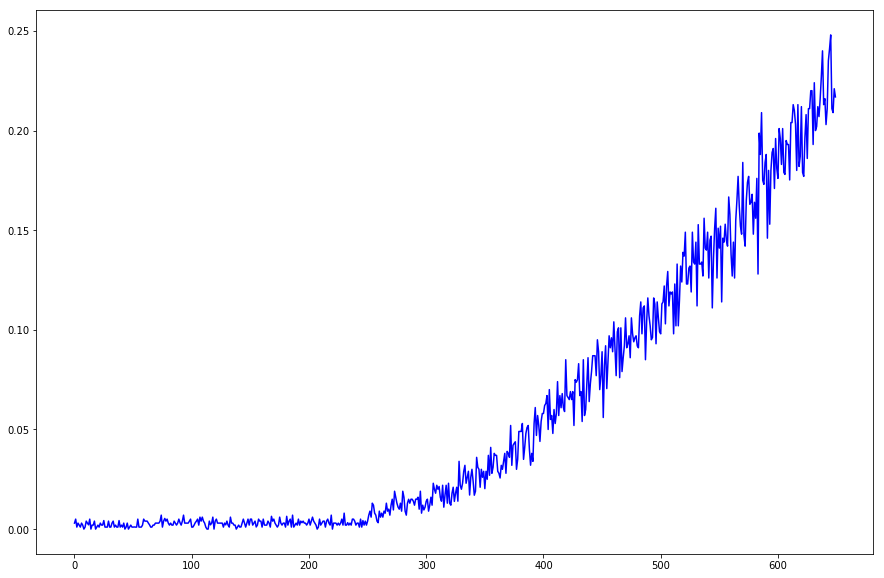

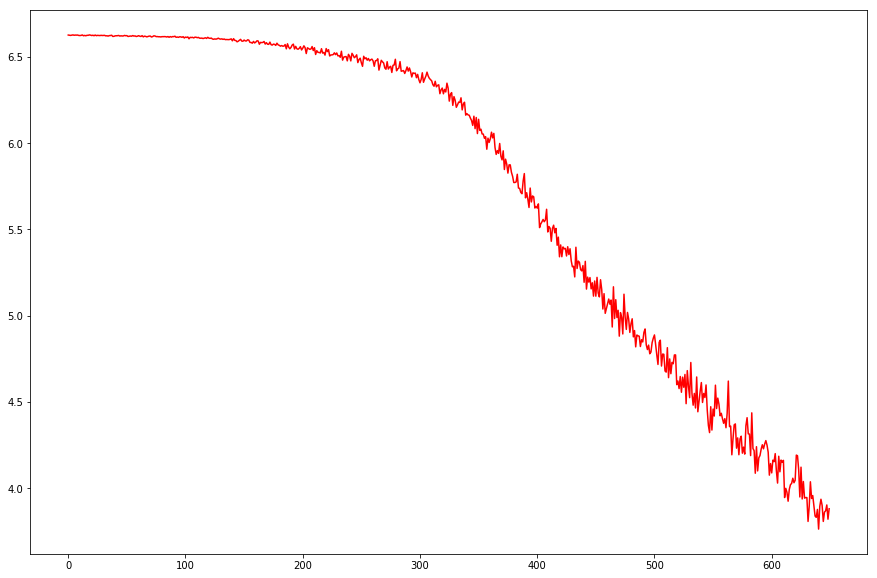

Time =  4104.423009395599
wd = 0.001 momentum = 0.8 lr =  0.1
Epoch [1/50], Step [4/13], Loss: 6.6230, Accuracy: 0.00000000%
Epoch [1/50], Step [8/13], Loss: 6.6129, Accuracy: 0.00200000%
Epoch [1/50], Step [12/13], Loss: 6.6070, Accuracy: 0.00100000%
Epoch [2/50], Step [4/13], Loss: 6.5842, Accuracy: 0.00500000%
Epoch [2/50], Step [8/13], Loss: 6.5642, Accuracy: 0.00700000%
Epoch [2/50], Step [12/13], Loss: 6.5396, Accuracy: 0.00400000%
Epoch [3/50], Step [4/13], Loss: 6.4685, Accuracy: 0.01000000%
Epoch [3/50], Step [8/13], Loss: 6.4622, Accuracy: 0.00900000%
Epoch [3/50], Step [12/13], Loss: 6.4834, Accuracy: 0.01200000%
Epoch [4/50], Step [4/13], Loss: 6.4233, Accuracy: 0.00800000%
Epoch [4/50], Step [8/13], Loss: 6.3583, Accuracy: 0.01400000%
Epoch [4/50], Step [12/13], Loss: 6.2945, Accuracy: 0.00900000%
Epoch [5/50], Step [4/13], Loss: 6.1826, Accuracy: 0.01900000%
Epoch [5/50], Step [8/13], Loss: 6.0374, Accuracy: 0.03100000%
Epoch [5/50], Step [12/13], Loss: 5.9152, Accuracy: 

Epoch [43/50], Step [4/13], Loss: 0.0062, Accuracy: 1.00000000%
Epoch [43/50], Step [8/13], Loss: 0.0083, Accuracy: 0.99900000%
Epoch [43/50], Step [12/13], Loss: 0.0065, Accuracy: 1.00000000%
Epoch [44/50], Step [4/13], Loss: 0.0033, Accuracy: 1.00000000%
Epoch [44/50], Step [8/13], Loss: 0.0027, Accuracy: 1.00000000%
Epoch [44/50], Step [12/13], Loss: 0.0030, Accuracy: 1.00000000%
Epoch [45/50], Step [4/13], Loss: 0.0028, Accuracy: 1.00000000%
Epoch [45/50], Step [8/13], Loss: 0.0026, Accuracy: 1.00000000%
Epoch [45/50], Step [12/13], Loss: 0.0026, Accuracy: 1.00000000%
Epoch [46/50], Step [4/13], Loss: 0.0025, Accuracy: 1.00000000%
Epoch [46/50], Step [8/13], Loss: 0.0021, Accuracy: 1.00000000%
Epoch [46/50], Step [12/13], Loss: 0.0024, Accuracy: 1.00000000%
Epoch [47/50], Step [4/13], Loss: 0.0020, Accuracy: 1.00000000%
Epoch [47/50], Step [8/13], Loss: 0.0024, Accuracy: 1.00000000%
Epoch [47/50], Step [12/13], Loss: 0.0023, Accuracy: 1.00000000%
Epoch [48/50], Step [4/13], Loss: 0

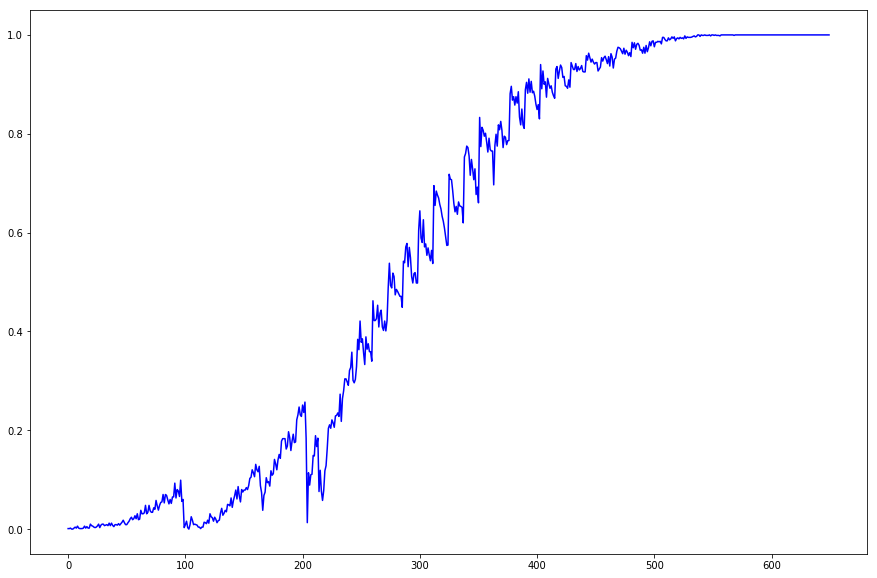

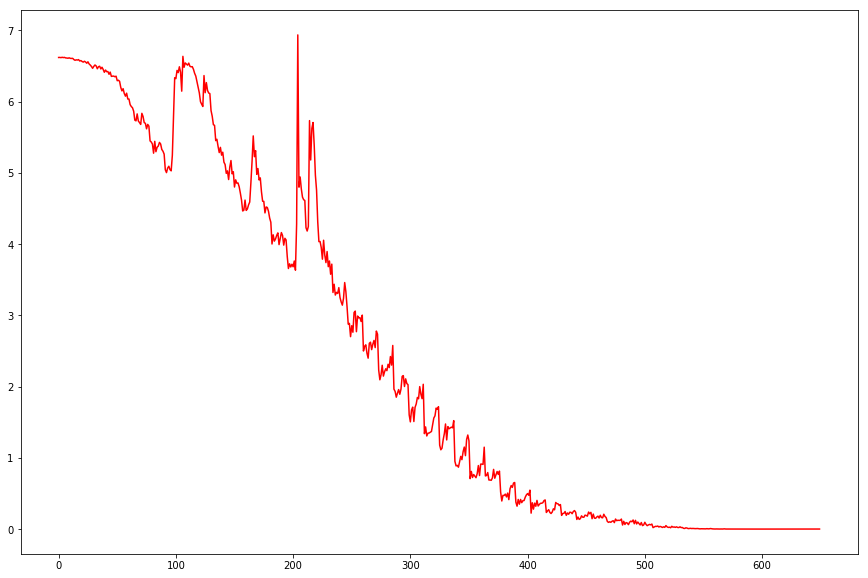

Time =  3971.8071768283844
wd = 0.001 momentum = 0.9 lr =  0.01
Epoch [1/50], Step [4/13], Loss: 6.6217, Accuracy: 0.00300000%
Epoch [1/50], Step [8/13], Loss: 6.6227, Accuracy: 0.00000000%
Epoch [1/50], Step [12/13], Loss: 6.6224, Accuracy: 0.00000000%
Epoch [2/50], Step [4/13], Loss: 6.6204, Accuracy: 0.00000000%
Epoch [2/50], Step [8/13], Loss: 6.6209, Accuracy: 0.00200000%
Epoch [2/50], Step [12/13], Loss: 6.6172, Accuracy: 0.00500000%
Epoch [3/50], Step [4/13], Loss: 6.6176, Accuracy: 0.00500000%
Epoch [3/50], Step [8/13], Loss: 6.6199, Accuracy: 0.00100000%
Epoch [3/50], Step [12/13], Loss: 6.6158, Accuracy: 0.00200000%
Epoch [4/50], Step [4/13], Loss: 6.6193, Accuracy: 0.00500000%
Epoch [4/50], Step [8/13], Loss: 6.6177, Accuracy: 0.00400000%
Epoch [4/50], Step [12/13], Loss: 6.6150, Accuracy: 0.00400000%
Epoch [5/50], Step [4/13], Loss: 6.6137, Accuracy: 0.00200000%
Epoch [5/50], Step [8/13], Loss: 6.6126, Accuracy: 0.00300000%
Epoch [5/50], Step [12/13], Loss: 6.6091, Accuracy

Epoch [43/50], Step [4/13], Loss: 2.4483, Accuracy: 0.45000000%
Epoch [43/50], Step [8/13], Loss: 2.6340, Accuracy: 0.41300000%
Epoch [43/50], Step [12/13], Loss: 2.6085, Accuracy: 0.45000000%
Epoch [44/50], Step [4/13], Loss: 2.3220, Accuracy: 0.48200000%
Epoch [44/50], Step [8/13], Loss: 2.5543, Accuracy: 0.44100000%
Epoch [44/50], Step [12/13], Loss: 2.4886, Accuracy: 0.44900000%
Epoch [45/50], Step [4/13], Loss: 2.1754, Accuracy: 0.50600000%
Epoch [45/50], Step [8/13], Loss: 2.2609, Accuracy: 0.48800000%
Epoch [45/50], Step [12/13], Loss: 2.2300, Accuracy: 0.50700000%
Epoch [46/50], Step [4/13], Loss: 1.8986, Accuracy: 0.54900000%
Epoch [46/50], Step [8/13], Loss: 1.9317, Accuracy: 0.56800000%
Epoch [46/50], Step [12/13], Loss: 2.1596, Accuracy: 0.51400000%
Epoch [47/50], Step [4/13], Loss: 1.8362, Accuracy: 0.59000000%
Epoch [47/50], Step [8/13], Loss: 1.8510, Accuracy: 0.58800000%
Epoch [47/50], Step [12/13], Loss: 2.0114, Accuracy: 0.54600000%
Epoch [48/50], Step [4/13], Loss: 1

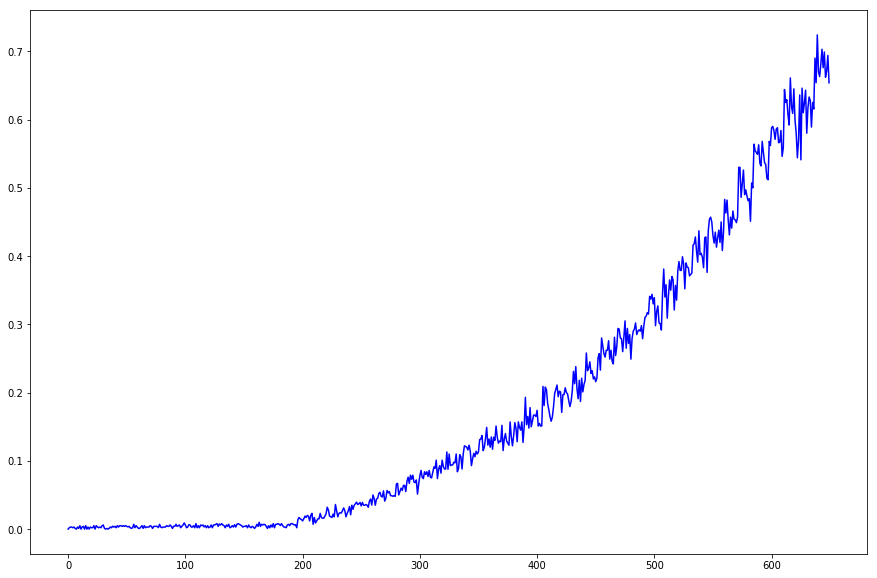

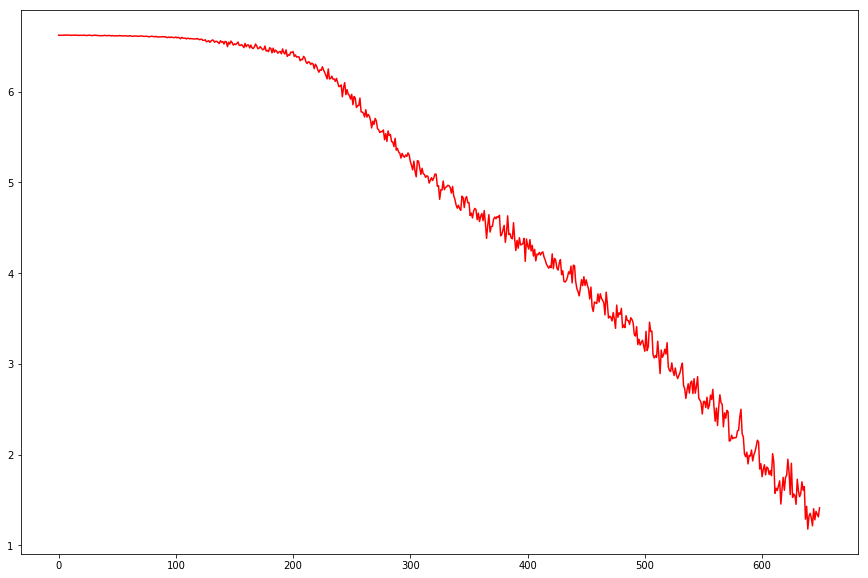

Time =  4013.8950505256653
wd = 0.001 momentum = 0.9 lr =  0.1
Epoch [1/50], Step [4/13], Loss: 6.6224, Accuracy: 0.00400000%
Epoch [1/50], Step [8/13], Loss: 6.6188, Accuracy: 0.00100000%
Epoch [1/50], Step [12/13], Loss: 6.6192, Accuracy: 0.00100000%
Epoch [2/50], Step [4/13], Loss: 6.6066, Accuracy: 0.00300000%
Epoch [2/50], Step [8/13], Loss: 6.5868, Accuracy: 0.00300000%
Epoch [2/50], Step [12/13], Loss: 6.5876, Accuracy: 0.00300000%
Epoch [3/50], Step [4/13], Loss: 6.5486, Accuracy: 0.00600000%
Epoch [3/50], Step [8/13], Loss: 6.5030, Accuracy: 0.00300000%
Epoch [3/50], Step [12/13], Loss: 6.5088, Accuracy: 0.00400000%
Epoch [4/50], Step [4/13], Loss: 6.4744, Accuracy: 0.00600000%
Epoch [4/50], Step [8/13], Loss: 6.4066, Accuracy: 0.01200000%
Epoch [4/50], Step [12/13], Loss: 6.3415, Accuracy: 0.00900000%
Epoch [5/50], Step [4/13], Loss: 6.2528, Accuracy: 0.01300000%
Epoch [5/50], Step [8/13], Loss: 6.0838, Accuracy: 0.02400000%
Epoch [5/50], Step [12/13], Loss: 5.9879, Accuracy:

Epoch [41/50], Step [12/13], Loss: 1036.9498, Accuracy: 0.00000000%
Epoch [42/50], Step [4/13], Loss: 2992.5671, Accuracy: 0.00100000%
Epoch [42/50], Step [8/13], Loss: 1702.2709, Accuracy: 0.00100000%
Epoch [42/50], Step [12/13], Loss: 1307.5269, Accuracy: 0.00100000%
Epoch [43/50], Step [4/13], Loss: 2978.5500, Accuracy: 0.00000000%
Epoch [43/50], Step [8/13], Loss: 3925.0789, Accuracy: 0.00400000%
Epoch [43/50], Step [12/13], Loss: 2931.5488, Accuracy: 0.00300000%
Epoch [44/50], Step [4/13], Loss: 3184.8318, Accuracy: 0.00200000%
Epoch [44/50], Step [8/13], Loss: 771.8744, Accuracy: 0.00100000%
Epoch [44/50], Step [12/13], Loss: 2201.9424, Accuracy: 0.00000000%
Epoch [45/50], Step [4/13], Loss: 1669.9817, Accuracy: 0.00000000%
Epoch [45/50], Step [8/13], Loss: 1227.1608, Accuracy: 0.00200000%
Epoch [45/50], Step [12/13], Loss: 2072.1235, Accuracy: 0.00000000%
Epoch [46/50], Step [4/13], Loss: 1370.1584, Accuracy: 0.00200000%
Epoch [46/50], Step [8/13], Loss: 365.2928, Accuracy: 0.00

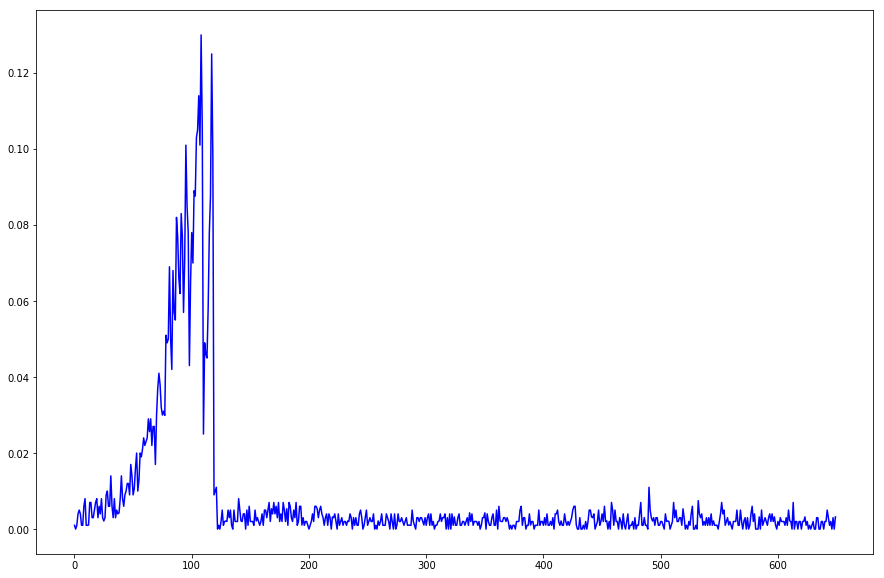

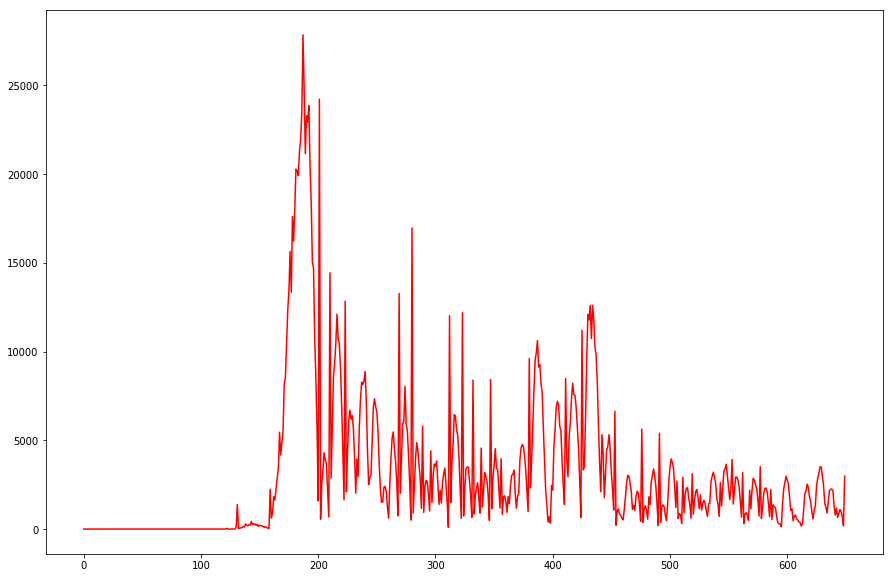

Time =  3979.3887901306152
wd = 0.01 momentum = 0.8 lr =  0.01
Epoch [1/50], Step [4/13], Loss: 6.6203, Accuracy: 0.00100000%
Epoch [1/50], Step [8/13], Loss: 6.6235, Accuracy: 0.00000000%
Epoch [1/50], Step [12/13], Loss: 6.6186, Accuracy: 0.00100000%
Epoch [2/50], Step [4/13], Loss: 6.6198, Accuracy: 0.00000000%
Epoch [2/50], Step [8/13], Loss: 6.6194, Accuracy: 0.00000000%
Epoch [2/50], Step [12/13], Loss: 6.6179, Accuracy: 0.00100000%
Epoch [3/50], Step [4/13], Loss: 6.6150, Accuracy: 0.00000000%
Epoch [3/50], Step [8/13], Loss: 6.6187, Accuracy: 0.00200000%
Epoch [3/50], Step [12/13], Loss: 6.6149, Accuracy: 0.00000000%
Epoch [4/50], Step [4/13], Loss: 6.6140, Accuracy: 0.00000000%
Epoch [4/50], Step [8/13], Loss: 6.6116, Accuracy: 0.00100000%
Epoch [4/50], Step [12/13], Loss: 6.6097, Accuracy: 0.00300000%
Epoch [5/50], Step [4/13], Loss: 6.6121, Accuracy: 0.00300000%
Epoch [5/50], Step [8/13], Loss: 6.6108, Accuracy: 0.00800000%
Epoch [5/50], Step [12/13], Loss: 6.6060, Accuracy:

Epoch [43/50], Step [4/13], Loss: 4.2883, Accuracy: 0.16300000%
Epoch [43/50], Step [8/13], Loss: 4.4730, Accuracy: 0.13600000%
Epoch [43/50], Step [12/13], Loss: 4.3599, Accuracy: 0.15400000%
Epoch [44/50], Step [4/13], Loss: 4.4931, Accuracy: 0.14200000%
Epoch [44/50], Step [8/13], Loss: 4.2653, Accuracy: 0.17000000%
Epoch [44/50], Step [12/13], Loss: 4.4593, Accuracy: 0.14000000%
Epoch [45/50], Step [4/13], Loss: 4.1611, Accuracy: 0.17500000%
Epoch [45/50], Step [8/13], Loss: 4.2296, Accuracy: 0.16200000%
Epoch [45/50], Step [12/13], Loss: 4.3380, Accuracy: 0.17000000%
Epoch [46/50], Step [4/13], Loss: 4.0040, Accuracy: 0.18900000%
Epoch [46/50], Step [8/13], Loss: 4.1495, Accuracy: 0.19400000%
Epoch [46/50], Step [12/13], Loss: 4.2501, Accuracy: 0.16400000%
Epoch [47/50], Step [4/13], Loss: 4.0951, Accuracy: 0.18900000%
Epoch [47/50], Step [8/13], Loss: 4.0954, Accuracy: 0.18800000%
Epoch [47/50], Step [12/13], Loss: 4.0355, Accuracy: 0.20200000%
Epoch [48/50], Step [4/13], Loss: 4

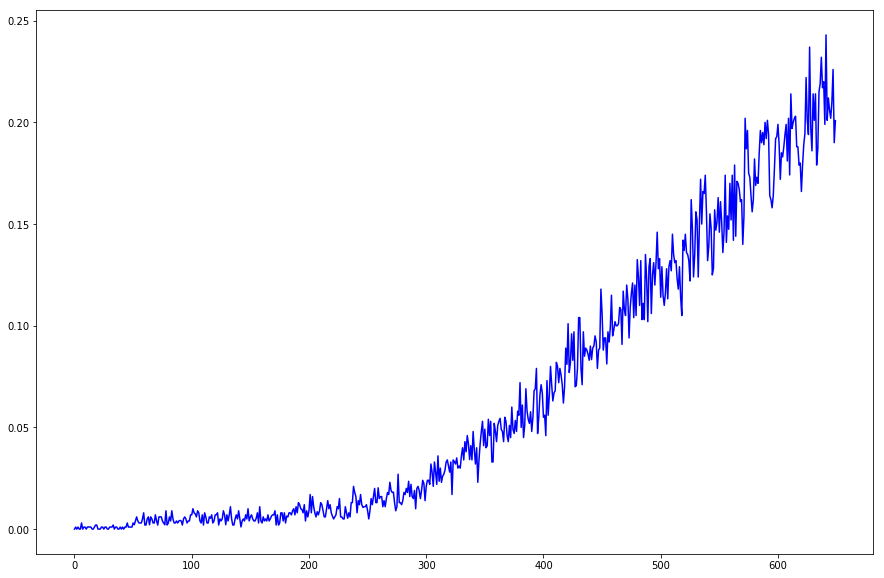

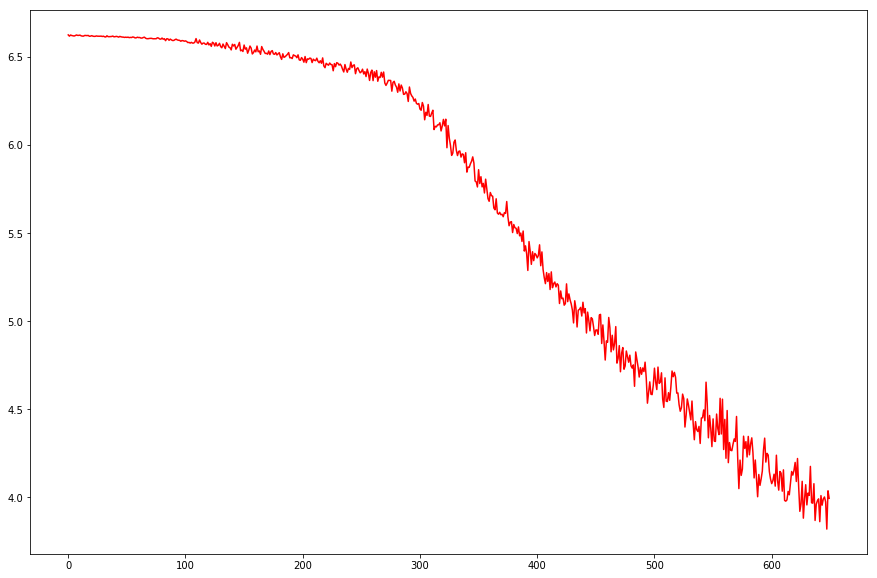

Time =  4079.8071665763855
wd = 0.01 momentum = 0.8 lr =  0.1
Epoch [1/50], Step [4/13], Loss: 6.6187, Accuracy: 0.00100000%
Epoch [1/50], Step [8/13], Loss: 6.6161, Accuracy: 0.00100000%
Epoch [1/50], Step [12/13], Loss: 6.6109, Accuracy: 0.00000000%
Epoch [2/50], Step [4/13], Loss: 6.5882, Accuracy: 0.00100000%
Epoch [2/50], Step [8/13], Loss: 6.5639, Accuracy: 0.01000000%
Epoch [2/50], Step [12/13], Loss: 6.5792, Accuracy: 0.00000000%
Epoch [3/50], Step [4/13], Loss: 6.4978, Accuracy: 0.01400000%
Epoch [3/50], Step [8/13], Loss: 6.5061, Accuracy: 0.00300000%
Epoch [3/50], Step [12/13], Loss: 6.4580, Accuracy: 0.00200000%
Epoch [4/50], Step [4/13], Loss: 6.4015, Accuracy: 0.02400000%
Epoch [4/50], Step [8/13], Loss: 6.3231, Accuracy: 0.01300000%
Epoch [4/50], Step [12/13], Loss: 6.2224, Accuracy: 0.03000000%
Epoch [5/50], Step [4/13], Loss: 6.0836, Accuracy: 0.01900000%
Epoch [5/50], Step [8/13], Loss: 5.9908, Accuracy: 0.02300000%
Epoch [5/50], Step [12/13], Loss: 5.7905, Accuracy: 

Epoch [43/50], Step [4/13], Loss: 6.4317, Accuracy: 0.00300000%
Epoch [43/50], Step [8/13], Loss: 6.4718, Accuracy: 0.00500000%
Epoch [43/50], Step [12/13], Loss: 6.4787, Accuracy: 0.00100000%
Epoch [44/50], Step [4/13], Loss: 6.4344, Accuracy: 0.00400000%
Epoch [44/50], Step [8/13], Loss: 6.4589, Accuracy: 0.00100000%
Epoch [44/50], Step [12/13], Loss: 6.4719, Accuracy: 0.00500000%
Epoch [45/50], Step [4/13], Loss: 6.4455, Accuracy: 0.00300000%
Epoch [45/50], Step [8/13], Loss: 6.4762, Accuracy: 0.00500000%
Epoch [45/50], Step [12/13], Loss: 6.4837, Accuracy: 0.00500000%
Epoch [46/50], Step [4/13], Loss: 6.4350, Accuracy: 0.00900000%
Epoch [46/50], Step [8/13], Loss: 6.4699, Accuracy: 0.00400000%
Epoch [46/50], Step [12/13], Loss: 6.4447, Accuracy: 0.00400000%
Epoch [47/50], Step [4/13], Loss: 6.4755, Accuracy: 0.00500000%
Epoch [47/50], Step [8/13], Loss: 6.4646, Accuracy: 0.00400000%
Epoch [47/50], Step [12/13], Loss: 6.4677, Accuracy: 0.00300000%
Epoch [48/50], Step [4/13], Loss: 6

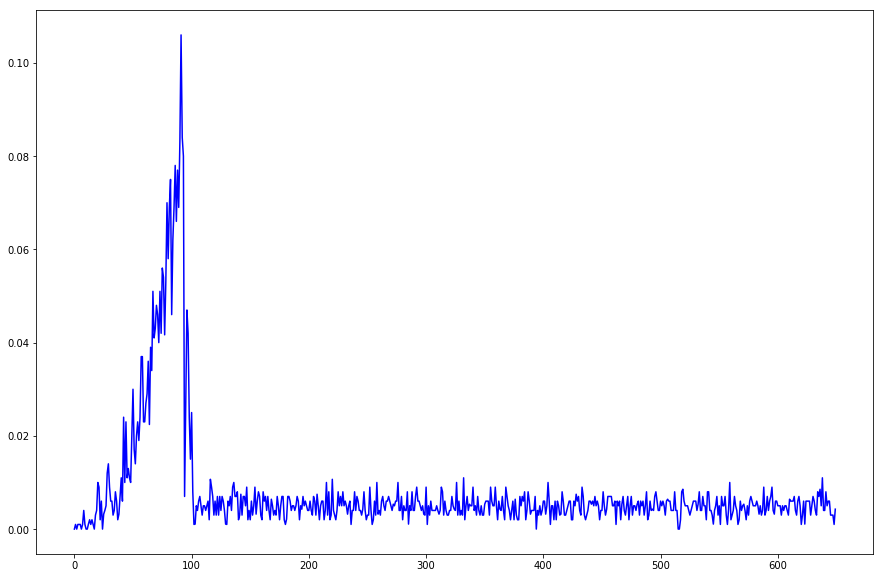

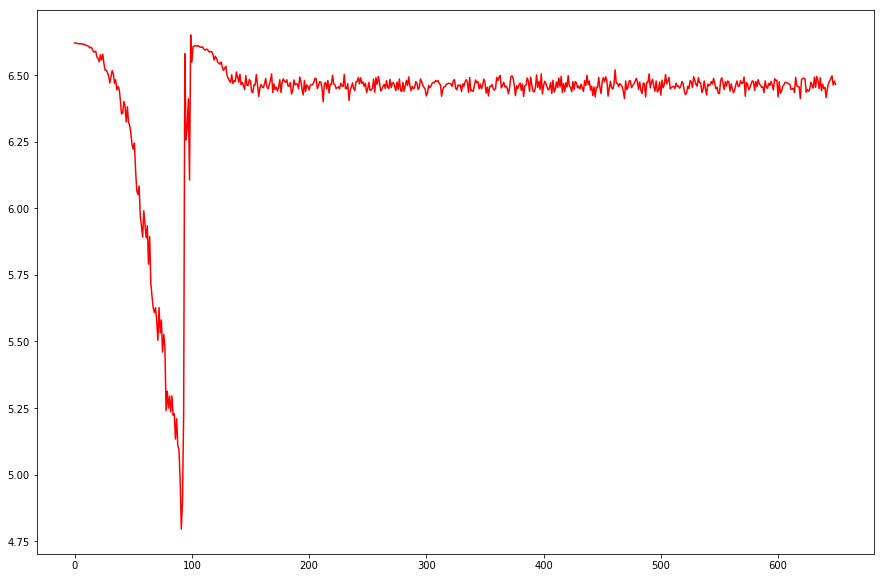

Time =  9763.55229640007
wd = 0.01 momentum = 0.9 lr =  0.01
Epoch [1/50], Step [4/13], Loss: 6.6214, Accuracy: 0.00500000%
Epoch [1/50], Step [8/13], Loss: 6.6220, Accuracy: 0.00400000%
Epoch [1/50], Step [12/13], Loss: 6.6192, Accuracy: 0.00000000%
Epoch [2/50], Step [4/13], Loss: 6.6146, Accuracy: 0.00100000%
Epoch [2/50], Step [8/13], Loss: 6.6150, Accuracy: 0.00100000%
Epoch [2/50], Step [12/13], Loss: 6.6150, Accuracy: 0.00200000%
Epoch [3/50], Step [4/13], Loss: 6.6129, Accuracy: 0.00100000%
Epoch [3/50], Step [8/13], Loss: 6.6107, Accuracy: 0.00100000%
Epoch [3/50], Step [12/13], Loss: 6.6054, Accuracy: 0.00200000%
Epoch [4/50], Step [4/13], Loss: 6.6050, Accuracy: 0.00200000%
Epoch [4/50], Step [8/13], Loss: 6.6034, Accuracy: 0.00500000%
Epoch [4/50], Step [12/13], Loss: 6.5917, Accuracy: 0.00200000%
Epoch [5/50], Step [4/13], Loss: 6.5870, Accuracy: 0.00100000%
Epoch [5/50], Step [8/13], Loss: 6.5820, Accuracy: 0.00300000%
Epoch [5/50], Step [12/13], Loss: 6.5830, Accuracy: 0

Epoch [43/50], Step [4/13], Loss: 1.5901, Accuracy: 0.62900000%
Epoch [43/50], Step [8/13], Loss: 1.6341, Accuracy: 0.60900000%
Epoch [43/50], Step [12/13], Loss: 1.5839, Accuracy: 0.62300000%
Epoch [44/50], Step [4/13], Loss: 1.3672, Accuracy: 0.66900000%
Epoch [44/50], Step [8/13], Loss: 1.4549, Accuracy: 0.65900000%
Epoch [44/50], Step [12/13], Loss: 1.6901, Accuracy: 0.59500000%
Epoch [45/50], Step [4/13], Loss: 1.2726, Accuracy: 0.68300000%
Epoch [45/50], Step [8/13], Loss: 1.3223, Accuracy: 0.66200000%
Epoch [45/50], Step [12/13], Loss: 1.4423, Accuracy: 0.65400000%
Epoch [46/50], Step [4/13], Loss: 1.1886, Accuracy: 0.70800000%
Epoch [46/50], Step [8/13], Loss: 1.1515, Accuracy: 0.71500000%
Epoch [46/50], Step [12/13], Loss: 1.1746, Accuracy: 0.69700000%
Epoch [47/50], Step [4/13], Loss: 0.9573, Accuracy: 0.74300000%
Epoch [47/50], Step [8/13], Loss: 0.9808, Accuracy: 0.76900000%
Epoch [47/50], Step [12/13], Loss: 1.1488, Accuracy: 0.70600000%
Epoch [48/50], Step [4/13], Loss: 0

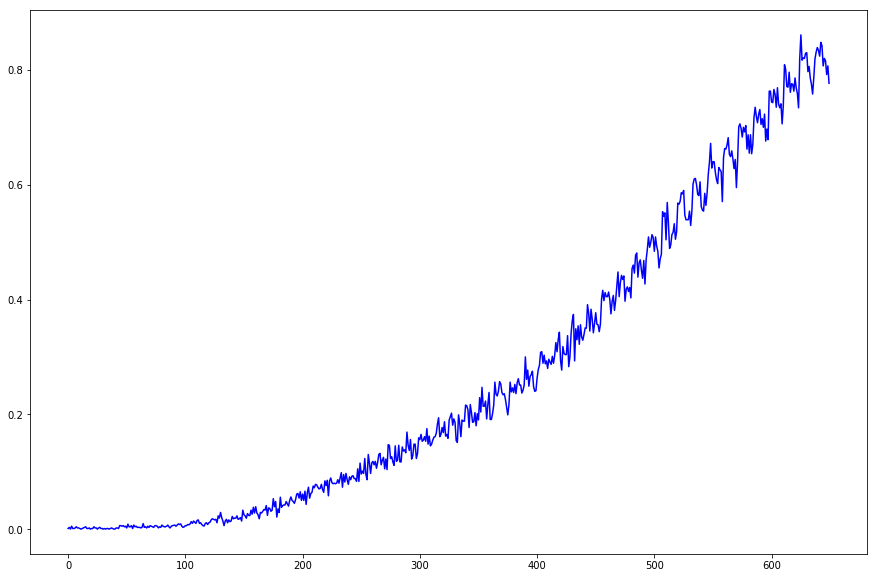

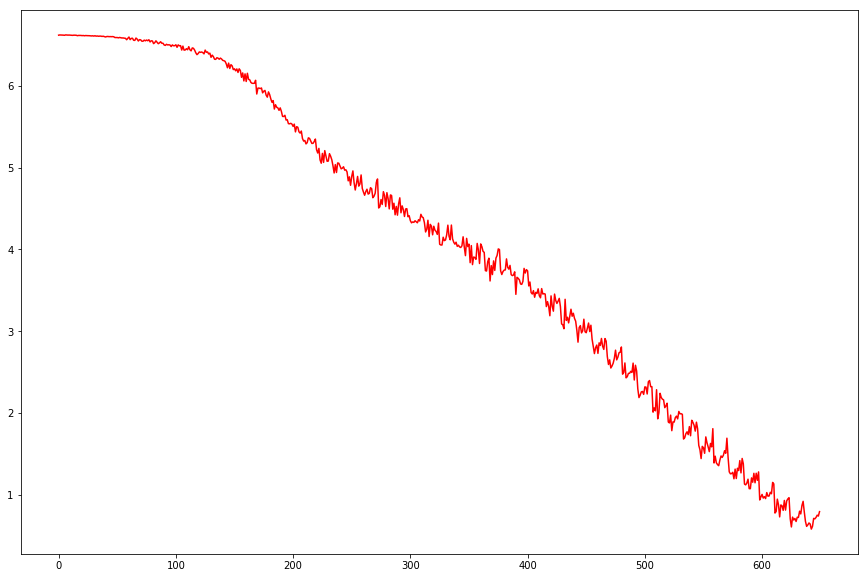

Time =  3988.577206134796
wd = 0.01 momentum = 0.9 lr =  0.1
Epoch [1/50], Step [4/13], Loss: 6.6188, Accuracy: 0.00000000%
Epoch [1/50], Step [8/13], Loss: 6.6191, Accuracy: 0.00100000%
Epoch [1/50], Step [12/13], Loss: 6.6122, Accuracy: 0.00100000%
Epoch [2/50], Step [4/13], Loss: 6.5998, Accuracy: 0.00200000%
Epoch [2/50], Step [8/13], Loss: 6.5682, Accuracy: 0.00100000%
Epoch [2/50], Step [12/13], Loss: 6.5740, Accuracy: 0.00400000%
Epoch [3/50], Step [4/13], Loss: 6.4928, Accuracy: 0.00500000%
Epoch [3/50], Step [8/13], Loss: 6.4789, Accuracy: 0.00300000%
Epoch [3/50], Step [12/13], Loss: 6.4919, Accuracy: 0.00400000%
Epoch [4/50], Step [4/13], Loss: 6.4560, Accuracy: 0.00300000%
Epoch [4/50], Step [8/13], Loss: 6.4519, Accuracy: 0.00600000%
Epoch [4/50], Step [12/13], Loss: 6.4447, Accuracy: 0.00600000%
Epoch [5/50], Step [4/13], Loss: 6.4124, Accuracy: 0.00600000%
Epoch [5/50], Step [8/13], Loss: 6.3547, Accuracy: 0.01000000%
Epoch [5/50], Step [12/13], Loss: 6.3227, Accuracy: 0

Epoch [43/50], Step [4/13], Loss: 6.4769, Accuracy: 0.00100000%
Epoch [43/50], Step [8/13], Loss: 6.4883, Accuracy: 0.00800000%
Epoch [43/50], Step [12/13], Loss: 6.5103, Accuracy: 0.00000000%
Epoch [44/50], Step [4/13], Loss: 6.5013, Accuracy: 0.00700000%
Epoch [44/50], Step [8/13], Loss: 6.4887, Accuracy: 0.00400000%
Epoch [44/50], Step [12/13], Loss: 6.4863, Accuracy: 0.00600000%
Epoch [45/50], Step [4/13], Loss: 6.4938, Accuracy: 0.00700000%
Epoch [45/50], Step [8/13], Loss: 6.5023, Accuracy: 0.00400000%
Epoch [45/50], Step [12/13], Loss: 6.5068, Accuracy: 0.00800000%
Epoch [46/50], Step [4/13], Loss: 6.4881, Accuracy: 0.00800000%
Epoch [46/50], Step [8/13], Loss: 6.4801, Accuracy: 0.00400000%
Epoch [46/50], Step [12/13], Loss: 6.4899, Accuracy: 0.00200000%
Epoch [47/50], Step [4/13], Loss: 6.4868, Accuracy: 0.00400000%
Epoch [47/50], Step [8/13], Loss: 6.4909, Accuracy: 0.00600000%
Epoch [47/50], Step [12/13], Loss: 6.4759, Accuracy: 0.00700000%
Epoch [48/50], Step [4/13], Loss: 6

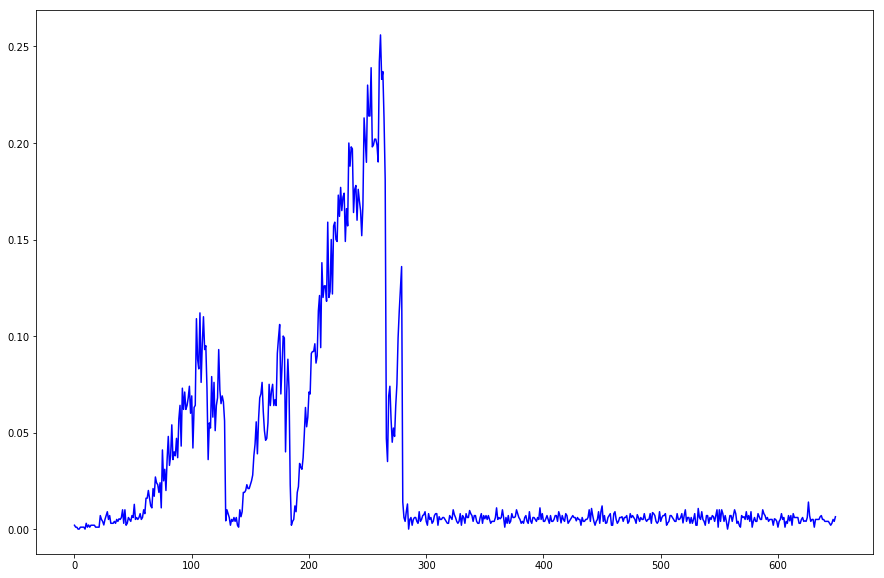

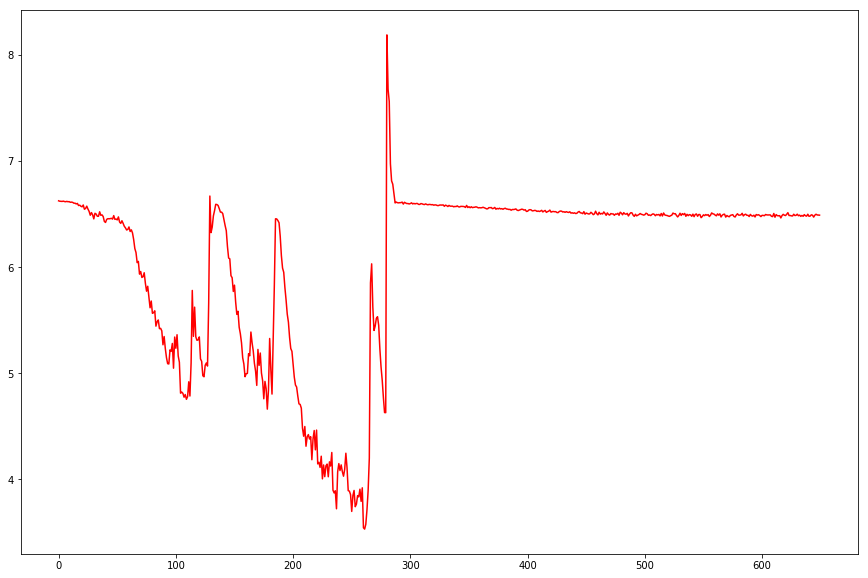

Time =  3914.6944761276245


In [40]:
num_epochs = 50
weight_decay_s = [0.001, 0.01]
momentum_s = [0.8, 0.9]
learning_rate_s = [0.01, 0.1]

for weight_decay in weight_decay_s:
    for momentum in momentum_s:
        for learning_rate in learning_rate_s:
            start_time = time.time()
            trainModel(num_epochs=num_epochs,
                       weight_decay=weight_decay,
                       momentum=momentum,
                       learning_rate=learning_rate)
            print("Time = ", time.time() - start_time)